## Step 1: Frame sorting

### Overview

The **PL data reduction process** begins with frame sorting — organizing PL frames based on the PSF peak coordinates. 


---

### Process Workflow

The frame sorting procedure involves four key stages:

1. **Timestamp Matching**  
   Match timestamps between the two cameras (The PSF camera usually runs faster than the PL camera.)

2. **PSF Peak Detection**  
   Identify PSF peaks within each frame

3. **Grid Definition**  
   Define a grid to sort the PL frames to

4. **Frame Sorting**  
   Sort PL frames into the defined grid and save them to a file

---


> **Note:** The examples in this notebook use a short dataset for demonstration purposes. The actual data are trimmed for this example.

### 1. Timestamp matching

In [46]:
import PLred.sort as sort
import matplotlib.pyplot as plt
import numpy as np
import importlib
importlib.reload(sort)

<module 'PLred.sort' from '/home/first/yjkim/PLred/PLred/sort.py'>

The below script generates three files:

1. **_fastcam_matched_frames.npy**  
   The PSF frames whose timestamps were matched to the PL frames
2. **.pkl**  
   Dictionary of matched file/frame indices.
3. **_nstacks.npy** 
   Number of stacked fastcam frames per slowcam frame

number of files found: 1


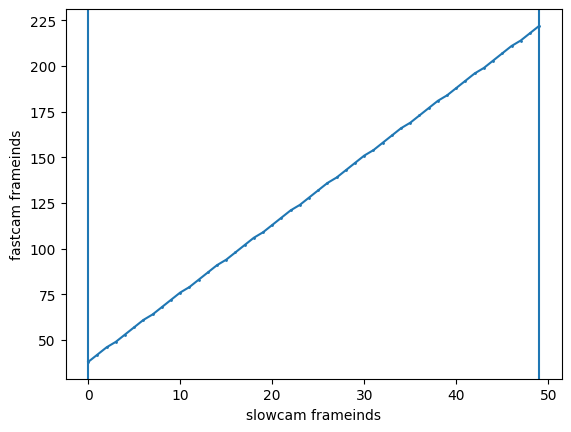

total slowcam images: 49


100%|██████████| 48/48 [00:00<00:00, 108240.10it/s]


timestamp matching file saved to timestamp_matching_output//first_palila_matched.pkl
saving cropped frames, [108:148, 140:180]
reading fastcam file data/fastcam/cropped_palila_15:05:10.002607418.fits


100%|██████████| 48/48 [00:00<00:00, 17087.64it/s]

matched fastcam frames saved to timestamp_matching_output//first_palila_matched_fastcam_matched_frames.npy


In [42]:
configname = 'timestamp_matching_config.ini'
sort.script_match_timestamps(configname)

Now we are ready to work with the simultaneous data!

Use `sort.FrameSorter` class to read these files.

In [47]:
plcam_timestamp_path = 'data/slowcam/'
plcam_spec_path = 'data/slowcam/'
psfcam_frames_name = 'timestamp_matching_output/first_palila_matched_fastcam_matched_frames.npy'
psfcam_timestamp_name = 'timestamp_matching_output/first_palila_matched.pkl'
obs_start = '15:05:17'
obs_end = '15:05:18'

sorter = sort.FrameSorter(plcam_timestamp_path, plcam_spec_path, psfcam_frames_name, psfcam_timestamp_name,
                 obs_start, obs_end, plcam_header = 'cropped_firstpl_')

number of files found: 1
number of files found: 1
Timestamp1 start: 2024-09-17 15:05:17.315891, end 2024-09-17 15:05:18.296350, length 50 
Timestamp2 start: 2024-09-17 15:05:17.315891, end 2024-09-17 15:05:18.256352, length 48 
Filtered 2 out of timestamp1, 0 out of timestamp2


### 2. PSF peak detection

Peak detection is done on all the frames by simply running `compute_psfcam_centroids()`.

Optionally, it is possible to pass the argument `peak = False` to find the center of mass instead of the peak. However I find it not as effective as the peak.

In [48]:
sorter.compute_psfcam_centroids()

Optionally, before binning the data, one may filter out bad frames. One simple way to do this is discarding frames of low Strehl (brightest pixel in the PSF frames).

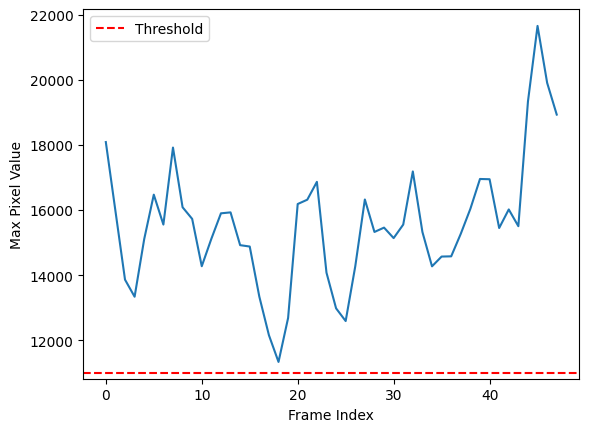

In [49]:
maxvals = np.max(sorter.psfcam_frames, axis=(1, 2))
thres = 11000
idx = maxvals > thres

plt.plot(maxvals)
plt.axhline(thres, color='red', linestyle='--', label='Threshold')
plt.xlabel('Frame Index')
plt.ylabel('Max Pixel Value')
plt.legend()
plt.show()

### 3. Grid definition

Now we sort the frames by the peak positions! `bin_by_centroids()` function does the frame sorting. 

First, we want to find a grid that works for the dataset - adequate number of samplings and field-of-view are needed. To prevent generating a lot of new files set `to_file = False` and `skip_frame_reading = True`. Then we experiment with a few different number of samplings and field-of-view.

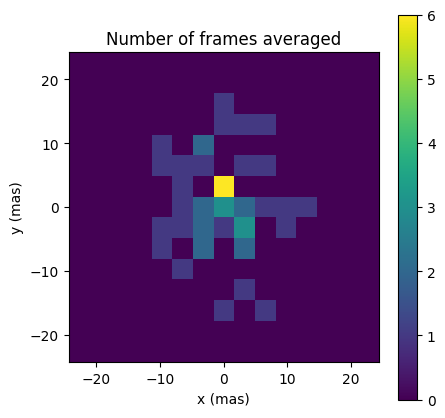

In [53]:
map_n = 15 # Number of samplings in the grid
map_width = 3 # Number of pixels (note, this number * pix2mas is the field-of-view in mas)

psfcam_binned_frames, num_frames, idxs = sorter.bin_by_centroids(map_n, map_width, effective_idx = idx,
                                                                 to_file = False, skip_frame_reading = True)

Definitely we don't need 15 X 15 grid for this small data!

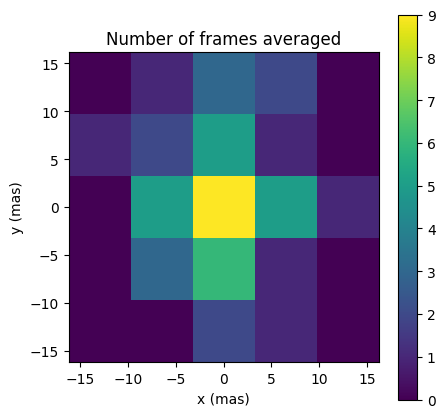

In [54]:
map_n = 5 # Number of samplings in the grid
map_width = 2 # Number of pixels (note, this number * pix2mas is the field-of-view in mas)

psfcam_binned_frames, num_frames, idxs = sorter.bin_by_centroids(map_n, map_width, effective_idx = idx,
                                                                 to_file = False, skip_frame_reading = True)

This looks better. Now we sort the PSF frames and PL frames. This script will generate a file per bin.

Info Saved to remapped/remapped_info.json
(2, 40, 40)
creating file remapped/remapped_bin_0_2.h5
(1, 40, 40)
creating file remapped/remapped_bin_0_3.h5
(3, 40, 40)
creating file remapped/remapped_bin_1_1.h5
(6, 40, 40)
creating file remapped/remapped_bin_1_2.h5
(1, 40, 40)
creating file remapped/remapped_bin_1_3.h5
(5, 40, 40)
creating file remapped/remapped_bin_2_1.h5
(9, 40, 40)
creating file remapped/remapped_bin_2_2.h5
(5, 40, 40)
creating file remapped/remapped_bin_2_3.h5
(1, 40, 40)
creating file remapped/remapped_bin_2_4.h5
(1, 40, 40)
creating file remapped/remapped_bin_3_0.h5
(2, 40, 40)
creating file remapped/remapped_bin_3_1.h5
(5, 40, 40)
creating file remapped/remapped_bin_3_2.h5
(1, 40, 40)
creating file remapped/remapped_bin_3_3.h5
(1, 40, 40)
creating file remapped/remapped_bin_4_1.h5
(3, 40, 40)
creating file remapped/remapped_bin_4_2.h5
(2, 40, 40)
creating file remapped/remapped_bin_4_3.h5


0it [00:00, ?it/s]

Start reading file 0
Added frame 0 from file 0 to bin 4,2
Added frame 1 from file 0 to bin 2,4
Added frame 2 from file 0 to bin 2,3
Added frame 3 from file 0 to bin 3,2
Added frame 4 from file 0 to bin 3,1
Added frame 5 from file 0 to bin 3,2
Added frame 6 from file 0 to bin 3,2
Added frame 7 from file 0 to bin 4,1
Added frame 8 from file 0 to bin 2,2
Added frame 9 from file 0 to bin 2,2
Added frame 10 from file 0 to bin 1,2
Added frame 11 from file 0 to bin 3,2
Added frame 12 from file 0 to bin 2,2
Added frame 13 from file 0 to bin 2,2
Added frame 14 from file 0 to bin 2,2
Added frame 15 from file 0 to bin 2,2
Added frame 16 from file 0 to bin 1,2
Added frame 17 from file 0 to bin 0,3
Added frame 18 from file 0 to bin 0,2
Added frame 19 from file 0 to bin 1,2
Added frame 20 from file 0 to bin 2,1
Added frame 21 from file 0 to bin 2,1
Added frame 22 from file 0 to bin 2,1
Added frame 23 from file 0 to bin 1,1
Added frame 24 from file 0 to bin 1,1
Added frame 25 from file 0 to bin 0,2
A

1it [00:00,  4.55it/s]

Added frame 42 from file 0 to bin 2,3
Added frame 43 from file 0 to bin 3,2
Added frame 44 from file 0 to bin 4,3
Added frame 45 from file 0 to bin 4,3
Added frame 46 from file 0 to bin 4,2
Added frame 47 from file 0 to bin 4,2
Saved plot to remapped/remapped_num_frames.png


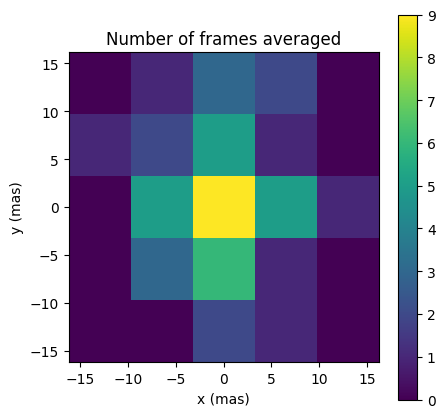

In [55]:
map_n = 5 # Number of samplings in the grid
map_width = 2 # Number of pixels (note, this number * pix2mas is the field-of-view in mas)

psfcam_binned_frames, num_frames, idxs = sorter.bin_by_centroids(map_n, map_width, effective_idx = idx,
                                                                 to_file = True, skip_frame_reading = False,
                                                                 filename = 'remapped/remapped')

Now we are done sorting frames!